In [13]:
import keras.backend as K
from keras import Input, Model, Sequential
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt
import json

import sys
sys.path.append("..")
from generative_models import utils

import metrics_utils
from sklearn import metrics

In [14]:
def build_regressor(timesteps, targets):
    model_inputs = Input((timesteps - targets,))
    regressed = model_inputs

    regressed = Dense(15, activation='relu')(regressed)
    regressed = Dense(5, activation='relu')(regressed)
    regressed = Dense(targets, activation = 'tanh')(regressed) 

    regressor = Model(model_inputs, regressed, 'regressor')
    regressor.compile(loss='mse', optimizer='adam') 
    return regressor

def evaluate_data(real_data, generated_data, targets, epochs):
    zero_value = metrics_utils.get_mode(real_data)

    (x_train, y_train), (x_test, y_test) = metrics_utils.combine_data_regression(real_data, generated_data, split, targets)
    
    step = 0.1
    metrics_utils.postprocess_dataset(x_train, zero_value, step)
    metrics_utils.postprocess_dataset(x_test, zero_value, step)
    
    regressor = build_regressor(timesteps, targets)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)
    regressor.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=epochs, verbose=1, callbacks=[early_stopping])
    y_predicted = regressor.predict(x_test)
        
    history = {}
    history['mse'] = metrics.mean_squared_error(y_test, y_predicted)
    history['r2'] = metrics.r2_score(y_test, y_predicted)
    
    return history

def run_comparison(real_data, generated_data_filepaths, labels, epochs):
    histories = {}
    
    for index, filepath in enumerate(generated_data_filepaths):
        print(labels[index])
        generated_data = np.load(filepath)[:elements]
        history = evaluate_data(real_data, generated_data, targets, epochs)
        histories[labels[index]] = history
    
    return histories

## Models comparison

In [15]:
timesteps = 90
elements = 50000
split = 0.3
targets = 20
epochs = 3

vanilla_color = 'r'
mbd_color = 'g'
packing_color = 'b'

transactions_filepath = '../../datasets/berka_dataset/usable/normalized_transactions_months.npy'
real_data = utils.load_splitted_dataset(transactions_filepath, timesteps)[:elements]
(values,counts) = np.unique(real_data,return_counts=True)
ind=np.argmax(counts)
zero_value = values[ind]

vanilla
Train on 70000 samples, validate on 30000 samples
Epoch 1/3
70000/70000 [==============================] - 11s 150us/step - loss: 0.0191 - val_loss: 0.0141
Epoch 2/3
70000/70000 [==============================] - 10s 139us/step - loss: 0.0136 - val_loss: 0.0133
Epoch 3/3
70000/70000 [==============================] - 11s 164us/step - loss: 0.0132 - val_loss: 0.0132
mbd
Train on 70000 samples, validate on 30000 samples
Epoch 1/3
70000/70000 [==============================] - 13s 191us/step - loss: 0.0094 - val_loss: 0.0059
Epoch 2/3
70000/70000 [==============================] - 16s 227us/step - loss: 0.0057 - val_loss: 0.0056
Epoch 3/3
70000/70000 [==============================] - 16s 225us/step - loss: 0.0055 - val_loss: 0.0054
packing
Train on 70000 samples, validate on 30000 samples
Epoch 1/3
70000/70000 [==============================] - 12s 168us/step - loss: 0.0187 - val_loss: 0.0158
Epoch 2/3
70000/70000 [==============================] - 12s 175us/step - loss: 0.0142 -

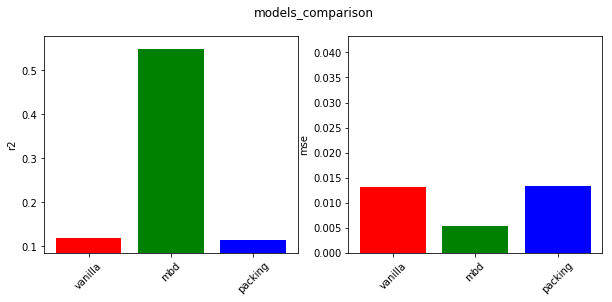

In [16]:
labels = ['vanilla', 'mbd', 'packing']
colors = [vanilla_color, mbd_color, packing_color]
title = 'models_comparison'

base_filepath = '../generative_models/wgan_gp/outputs/final/'
end_filename = 'generated_datasets/last.npy'
generated_data_filepaths = []       
for label in labels:
    generated_data_filepaths.append(base_filepath + label + '/' + end_filename)
    
histories = run_comparison(real_data, generated_data_filepaths, labels, epochs)
metrics_utils.plot_metrics(histories, labels, colors, title)

metrics_utils.save_to_json('nn_regression_models_comparison.json', histories)

## Performance analysis during training

In [17]:
timesteps = 90
elements = 50000
split = 0.3

labels = ['100k', '200k', '300k', '400k', '500k', '600k', '700k', '800k', '900k', '1M']

transactions_filepath = '../../datasets/berka_dataset/usable/normalized_transactions_months.npy'
real_data = utils.load_splitted_dataset(transactions_filepath, timesteps)[:elements]

### Vanilla

In [18]:
colors = [vanilla_color] * 10
title = 'vanilla'

base_filepath = '../generative_models/wgan_gp/outputs/final/vanilla/generated_datasets/'
generated_data_filepaths = []

for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories = run_comparison(real_data, generated_data_filepaths, labels, epochs)
plot_metrics(histories, labels, colors, title)

metrics_utils.save_to_json('nn_regression_vanilla.json', histories)

TypeError: run_comparison() missing 2 required positional arguments: 'labels' and 'epochs'

### Mbd

In [ ]:
colors = [mbd_color] * 10
title = 'mbd'

base_filepath = '../generative_models/wgan_gp/outputs/final/mbd/generated_datasets/'
generated_data_filepaths = []
for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories = run_comparison(real_data, generated_data_filepaths, labels, epochs)
plot_metrics(histories, labels, colors, title)

metrics_utils.save_to_json('nn_regression_mbd.json', histories)

### Packing

In [ ]:
colors = [packing_color] * 10
title = 'packing'

base_filepath = '../generative_models/wgan_gp/outputs/final/packing/generated_datasets/'
generated_data_filepaths = []
for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories = run_comparison(real_data, generated_data_filepaths, labels, epochs)
plot_metrics(histories, labels, colors, title)

metrics_utils.save_to_json('nn_regression_packing.json', histories)